In [20]:
import os

import glob
from PIL import Image
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

import pytorch_lightning as pl # pip install pytorch-lightning
from torchmetrics.functional import (accuracy, structural_similarity_index_measure as ssim,
                                     peak_signal_noise_ratio as psnr) # pip install torchmetrics psnr, ssim,

from torchsummary import summary # pip install torchsummary
import segmentation_models_pytorch as smp # pip install segmentation-models-pytorch

print(f'Pytorch: {torch.__version__}')
print(f'Pytorch Vision: {torchvision.__version__}')
print(f'Pytorch Lightning: {pl.__version__}')

Pytorch: 1.13.0+cpu
Pytorch Vision: 0.14.0+cpu
Pytorch Lightning: 1.8.3.post1


In [2]:
DATASET_TRAIN_PATH = r'.\datasets\facades\train'
DATASET_TEST_PATH = r'.\datasets\facades\test'
TRAIN_BATCH_SIZE = 32
TRAIN_IMAGE_SIZE = 256
VAL_BATCH_SIZE = 16
VAL_IMAGE_SIZE = 256
TEST_BATCH_SIZE = 20
TEST_IMAGE_SIZE = 256
LAMBDA = 100
NUM_EPOCH = 20
AVAILABLE_GPUS = torch.cuda.device_count()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cpu'

In [5]:
class HorizontalSplit(torch.nn.Module):
    def __init__(self, ratio=0.5):
        super(HorizontalSplit, self).__init__()
        self.ratio = ratio

    def forward(self, image):
        w, h = image.size
        idx = int(w * self.ratio)
        left = TF.crop(image, top=0, left=0, height=h, width=idx)
        right = TF.crop(image, top=0, left=idx, height=h, width=idx)
        return left, right

class SketchDataset(Dataset):
    def __init__(self, filenames, split='train', transform=None):
        self.filenames = filenames
        self.split = split

        # Data transform
        if not transform:
            if self.split == 'train':
                self.transform = transforms.Compose([
                    HorizontalSplit(0.5),
                    transforms.Lambda(lambda images: torch.stack([transforms.ToTensor()(item) for item in images])),
                    transforms.CenterCrop((TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(45, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, fill=1),
                ])
            elif self.split == 'val':
                self.transform = transforms.Compose([
                    HorizontalSplit(0.5),
                    transforms.Lambda(lambda images: torch.stack([transforms.ToTensor()(item) for item in images])),
                    transforms.CenterCrop((VAL_IMAGE_SIZE, VAL_IMAGE_SIZE)),
                ])
            else:
                self.transform = transforms.Compose([
                    HorizontalSplit(0.5),
                    transforms.Lambda(lambda images: torch.stack([transforms.ToTensor()(item) for item in images])),
                ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        image = self.transform(image)
        target, image = torch.split(image, 1)
        image = torch.squeeze(image)
        target = torch.squeeze(target)
        return image, target

In [6]:
filenames = sorted(glob.glob(f'{DATASET_TRAIN_PATH}/*.jpg'))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.1)
print(f'Train dataset: {len(train_filenames)} - Validation dataset: {len(val_filenames)}')

Train dataset: 360 - Validation dataset: 40


In [7]:
from joblib.externals.loky.backend import get_context

train_dataset = SketchDataset(train_filenames, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=8, shuffle=True, drop_last=True,
                             multiprocessing_context=get_context('loky'))


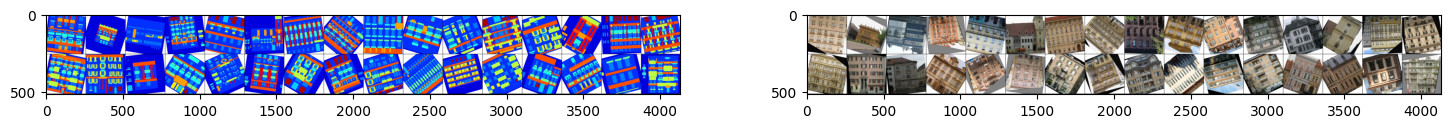

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))

data = next(iter(train_dataloader))
image, target = data

grid_image = torchvision.utils.make_grid(image, nrow=16)
ax1.imshow(grid_image.permute(1, 2, 0))
grid_image = torchvision.utils.make_grid(target, nrow=16)
ax2.imshow(grid_image.permute(1, 2, 0))

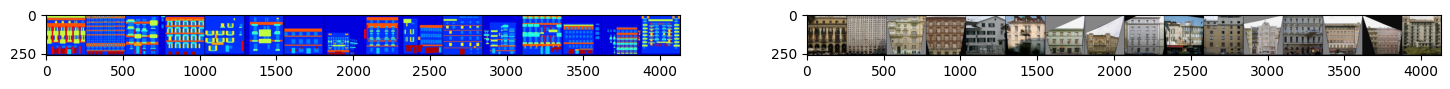

In [9]:
val_dataset = SketchDataset(val_filenames, split='val')
val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, num_workers=8, shuffle=False,
                             multiprocessing_context=get_context('loky'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))

data = next(iter(val_dataloader))
image, target = data
grid_image = torchvision.utils.make_grid(image, nrow=16)
ax1.imshow(grid_image.permute(1, 2, 0))
grid_image = torchvision.utils.make_grid(target, nrow=16)
ax2.imshow(grid_image.permute(1, 2, 0))

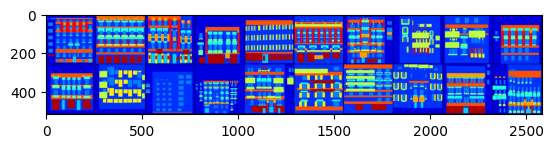

In [10]:
test_filenames = sorted(glob.glob(f'{DATASET_TEST_PATH}/*.jpg'))
test_dataset = SketchDataset(test_filenames, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

data = next(iter(test_dataloader))
image, target = data
grid_image = torchvision.utils.make_grid(image, nrow=10)
plt.imshow(grid_image.permute(1, 2, 0))

Используем в качестве генератора обученную на Imagenet сеть Unet с Resnet

In [11]:
class Generator(nn.Module):
    def __init__(self, dropout_p=0.4):
        super(Generator, self).__init__()
        self.dropout_p = dropout_p
        self.unet = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",
                             in_channels=3, classes=3, activation=None)
        for idx in range(1, 3):
            self.unet.decoder.blocks[idx].conv1.add_module('3', nn.Dropout2d(p=self.dropout_p))
        for module in self.unet.modules():
            if isinstance(module, nn.ReLU):
                module.inplace = False

    def forward(self, x):
        x = self.unet(x)
        x = F.relu(x)
        return x

In [12]:
generator = Generator()
summary(generator, input_size=(3, 256, 256), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

В качестве дискриминатора свёрточная сеть:

In [13]:
class Discriminator(nn.Module):
    def __init__(self, dropout_p=0.4):
        super(Discriminator, self).__init__()
        self.dropout_p = dropout_p
        self.model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(6, 128, 3, stride=2, padding=2)),
          ('bn1', nn.BatchNorm2d(128)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(128, 256, 3, stride=2, padding=2)),
          ('bn2', nn.BatchNorm2d(256)),
          ('relu2', nn.ReLU()),
          ('conv3', nn.Conv2d(256, 512, 3)),
          ('dropout3', nn.Dropout2d(p=self.dropout_p)),
          ('bn3', nn.BatchNorm2d(512)),
          ('relu3', nn.ReLU()),
          ('conv4', nn.Conv2d(512, 1024, 3)),
          ('dropout4', nn.Dropout2d(p=self.dropout_p)),
          ('bn4', nn.BatchNorm2d(1024)),
          ('relu4', nn.ReLU()),
          ('conv5', nn.Conv2d(1024, 512, 3, stride=2, padding=2)),
          ('dropout5', nn.Dropout2d(p=self.dropout_p)),
          ('bn5', nn.BatchNorm2d(512)),
          ('relu5', nn.ReLU()),
          ('conv6', nn.Conv2d(512, 256, 3, stride=2, padding=2)),
          ('dropout6', nn.Dropout2d(p=self.dropout_p)),
          ('bn6', nn.BatchNorm2d(256)),
          ('relu6', nn.ReLU()),
          ('conv7', nn.Conv2d(256, 128, 3)),
          ('bn7', nn.BatchNorm2d(128)),
          ('relu7', nn.ReLU()),
          ('conv8', nn.Conv2d(128, 1, 3)),
        ]))

    def forward(self, x):
        x = self.model(x)
        x = sigmoid(x)
        return  x

In [14]:
class Pix2Pix(pl.LightningModule):
    def __init__(self, generator_dropout_p=0.4, discriminator_dropout_p=0.4, generator_lr=1e-3, discriminator_lr=1e-6,
                 weight_decay=1e-5, lr_scheduler_T_0=1e3, lr_scheduler_T_mult=2):
        super(Pix2Pix, self).__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.generator_lr = generator_lr
        self.discriminator_lr = discriminator_lr
        self.weight_decay = weight_decay
        self.lr_scheduler_T_0 = lr_scheduler_T_0
        self.lr_scheduler_T_mult = lr_scheduler_T_mult

        self.generator = Generator(dropout_p=generator_dropout_p)
        self.discriminator = Discriminator(dropout_p=discriminator_dropout_p)

    def forward(self, x):
        return self.generator(x)

    def generator_loss(self, prediction_image, target_image, prediction_label, target_label):
        bce_loss = F.binary_cross_entropy(prediction_label, target_label)
        l1_loss = F.l1_loss(prediction_image, target_image)
        mse_loss = F.mse_loss(prediction_image, target_image)
        return bce_loss, l1_loss, mse_loss

    def discriminator_loss(self, prediction_label, target_label):
        bce_loss = F.binary_cross_entropy(prediction_label, target_label)
        return bce_loss

    def configure_optimizers(self):
        generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=self.generator_lr, weight_decay=self.weight_decay)
        discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=self.discriminator_lr, weight_decay=self.weight_decay)
        # Learning Scheduler
        genertator_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(generator_optimizer, T_0=self.lr_scheduler_T_0, T_mult=self.lr_scheduler_T_mult)
        discriminator_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(discriminator_optimizer, T_0=self.lr_scheduler_T_0, T_mult=self.lr_scheduler_T_mult)
        return [generator_optimizer, discriminator_optimizer], [genertator_lr_scheduler, discriminator_lr_scheduler]

    def training_step(self, batch, batch_idx):
        generator_optimizer, discriminator_optimizer = self.optimizers()
        generator_lr_scheduler, discriminator_lr_scheduler = self.lr_schedulers()

        image, target = batch
        image_i, image_j = torch.split(image, TRAIN_BATCH_SIZE // 2)
        target_i, target_j = torch.split(target, TRAIN_BATCH_SIZE // 2)

        generator_prediction = self.forward(image_i)
        generator_prediction = torch.clip(generator_prediction, 0, 1)

        discriminator_prediction_real = self.discriminator(torch.cat((image_i, target_i), dim=1))
        discriminator_prediction_fake = self.discriminator(torch.cat((image_i, generator_prediction), dim=1))

        discriminator_label_real = self.discriminator_loss(discriminator_prediction_real,
                                                           torch.ones_like(discriminator_prediction_real))
        discriminator_label_fake = self.discriminator_loss(discriminator_prediction_fake,
                                                           torch.zeros_like(discriminator_prediction_fake))
        discriminator_loss = discriminator_label_real + discriminator_label_fake

        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
        discriminator_lr_scheduler.step()

        generator_prediction = self.forward(image_j)
        generator_prediction = torch.clip(generator_prediction, 0, 1)

        discriminator_prediction_fake = self.discriminator(torch.cat((image_j, generator_prediction), dim=1))

        generator_bce_loss, generator_l1_loss, generator_mse_loss = self.generator_loss(generator_prediction, target_j,
                                                                                        discriminator_prediction_fake,
                                                                                        torch.ones_like(discriminator_prediction_fake))
        generator_loss = generator_bce_loss + (generator_l1_loss * LAMBDA) + (generator_mse_loss * LAMBDA)

        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        generator_lr_scheduler.step()

        loss = OrderedDict({'train_g_bce_loss': generator_bce_loss, 'train_g_l1_loss': generator_l1_loss, 'train_g_mse_loss': generator_mse_loss,
                            'train_g_loss': generator_loss, 'train_d_loss': discriminator_loss,
                            'train_g_lr': generator_lr_scheduler.get_last_lr()[0], 'train_d_lr': discriminator_lr_scheduler.get_last_lr()[0]})
        self.log_dict(loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, target = batch

        generator_prediction = self.forward(image)
        generator_prediction = torch.clip(generator_prediction, 0, 1)

        # generator_psnr = psnr(generator_prediction, target)
        # generator_ssim = ssim(generator_prediction, target)
        discriminator_prediction_fake = self.discriminator(torch.cat((image, generator_prediction), dim=1))
        generator_accuracy = accuracy(discriminator_prediction_fake, torch.ones_like(discriminator_prediction_fake, dtype=torch.int32), task='binary')

        discriminator_prediction_real = self.discriminator(torch.cat((image, target), dim=1))
        discriminator_prediction_fake = self.discriminator(torch.cat((image, generator_prediction), dim=1))

        discriminator_accuracy = accuracy(discriminator_prediction_real, torch.ones_like(discriminator_prediction_real, dtype=torch.int32), task='binary') * 0.5 + \
                                accuracy(discriminator_prediction_fake, torch.zeros_like(discriminator_prediction_fake, dtype=torch.int32), task='binary') * 0.5

        metrics = OrderedDict({'val_g_accuracy': generator_accuracy, 'val_d_accuracy': discriminator_accuracy})
        # metrics = OrderedDict({'val_g_psnr': generator_psnr, 'val_g_ssim': generator_ssim,
        #                        'val_g_accuracy': generator_accuracy, 'val_d_accuracy': discriminator_accuracy})

        self.log_dict(metrics, prog_bar=True)
        return metrics

In [15]:
class EpochInference(pl.callbacks.Callback):
    def __init__(self, dataloader, *args, **kwargs):
        super(EpochInference, self).__init__(*args, **kwargs)
        self.dataloader = dataloader

    def on_train_epoch_end(self, trainer, pl_module):
        super(EpochInference, self).on_train_epoch_end(trainer, pl_module)
        data = next(iter(self.dataloader))
        image, target = data
        image = image.to(device)
        target = target.to(device)
        with torch.no_grad():
            reconstruction_init = pl_module.forward(image)
            reconstruction_init = torch.clip(reconstruction_init, 0, 1)

            reconstruction_mean = torch.stack([pl_module.forward(image) for _ in range(100)])
            reconstruction_mean = torch.clip(reconstruction_mean, 0, 1)
            reconstruction_mean = torch.mean(reconstruction_mean, dim=0)

        image = torch.squeeze(image)
        grid_image = torchvision.utils.make_grid(torch.cat([image, target, reconstruction_init, reconstruction_mean], dim=0), nrow=20)
        torchvision.utils.save_image(grid_image, fp=f'{trainer.log_dir}/epoch-{trainer.current_epoch:04}.png')

In [16]:
epoch_inference_callback = EpochInference(test_dataloader)
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint()

model = Pix2Pix(generator_dropout_p=0.4, discriminator_dropout_p=0.25,
                generator_lr=1e-3, discriminator_lr=1e-5,
                lr_scheduler_T_0=len(train_dataloader) * 2)

trainer = pl.Trainer(accelerator=device, max_epochs=NUM_EPOCH, val_check_interval=0.5, default_root_dir='./pix2pix/',
                     callbacks=[epoch_inference_callback, checkpoint_callback], log_every_n_steps=2)  #
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 24.4 M
1 | discriminator | Discriminator | 12.4 M
------------------------------------------------
36.8 M    Trainable params
0         Non-trainable params
36.8 M    Total params
147.358   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Загрузка последней модели

In [23]:
model

Pix2Pix(
  (generator): Generator(
    (unet): Unet(
      (encoder): ResNetEncoder(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [ ]:
import os

checkpoint = sorted(glob.glob('./pix2pix/checkpoints/*.ckpt'), key=os.path.getmtime)[0]
checkpoint = torch.load(checkpoint)
model = Pix2Pix()
model.load_state_dict(checkpoint['state_dict'], strict=True)

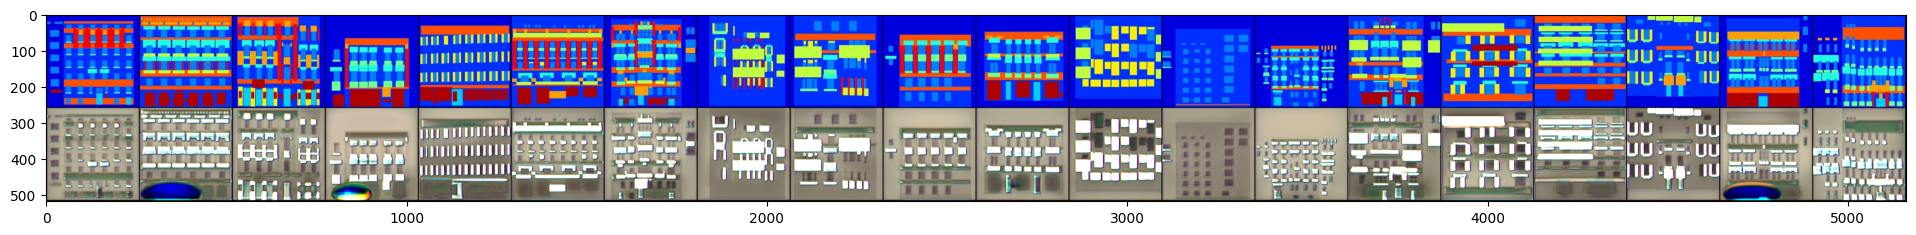

In [25]:
data = next(iter(test_dataloader))
image, _ = data
with torch.no_grad():
    reconstruction = model(image)
    reconstruction = torch.clip(reconstruction, 0, 1)

image = torch.squeeze(image)
grid_image = torchvision.utils.make_grid(torch.cat([image, reconstruction]), nrow=20)
plt.figure(figsize=(24, 24))
plt.imshow(grid_image.permute(1, 2, 0))

За 20 эпох обучения pix2pix рисует что-то отдаленно похожее на дома.